In [6]:
!pip install keras_tuner

In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from itertools import combinations
from matplotlib.cm import ScalarMappable
from PIL import Image as imge
from keras.models import Sequential, Model, load_model
from keras import callbacks
from keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from keras.optimizers import Adam
import datetime
import os
import keras
import keras.regularizers as l2
import pickle
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Model
from IPython.display import Image, display
from sklearn.model_selection import train_test_split
from keras.utils import plot_model, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.graph_objects as go
from timeit import default_timer as timer
import timeit
import seaborn as sns
import sklearn.metrics
import keras_tuner

2023-02-25 17:33:13.764792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
#loading dataset 
mnist = tf.keras.datasets.mnist
(x_train, y_train) , (x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

#rescaling data to [-1,1]
x_train, x_test = x_train/ 127.5 - 1, x_test /127.5 -1

# resizing dataset 
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

We build a bar chart of training and test data to check out the number of data samples across the classes.

Text(0.5, 1.0, 'Labels in MNIST dataset')

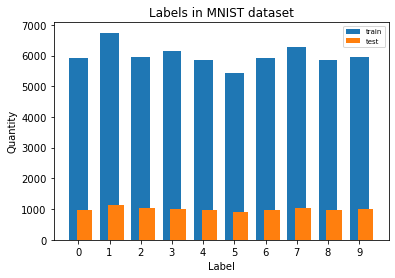

In [3]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts_t = np.unique(y_test, return_counts=True)

plt.bar(unique, counts, width=0.6, label='train')
plt.bar(unique+0.2, counts_t, width=0.5, label='test')

plt.xticks(unique)
plt.xlabel("Label")
plt.ylabel("Quantity")
plt.legend(loc= 'upper right', prop={'size': 7})
plt.title("Labels in MNIST dataset")

Both training and testing  dataset are balanced. 

# Task 1

Reduce dimensionality by using PCA method to 2D space then visualize the results using matplotlib library.

Explained variation by the two principal components : [0.09704664 0.07095924] respectively


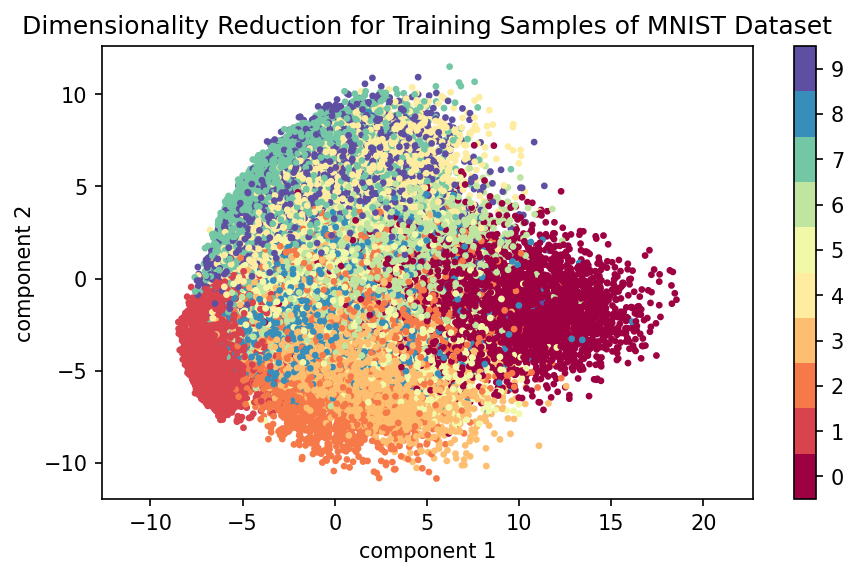

In [32]:
# reduce dimension to 2D  
pca = PCA(n_components=2)
X_train_new = pca.fit_transform(x_train)

print('Explained variation by the two principal components : {} respectively'.format(pca.explained_variance_ratio_))
plt.figure(figsize=(7, 4), dpi=150)
plt.scatter(X_train_new[:, 0], X_train_new[:, 1],
             s= 5, c=y_train, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dimensionality Reduction for Training Samples of MNIST Dataset')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

We twisted the visualization to present only the first 400 training sample using the number itself as a marker.

<function matplotlib.pyplot.show(close=None, block=None)>

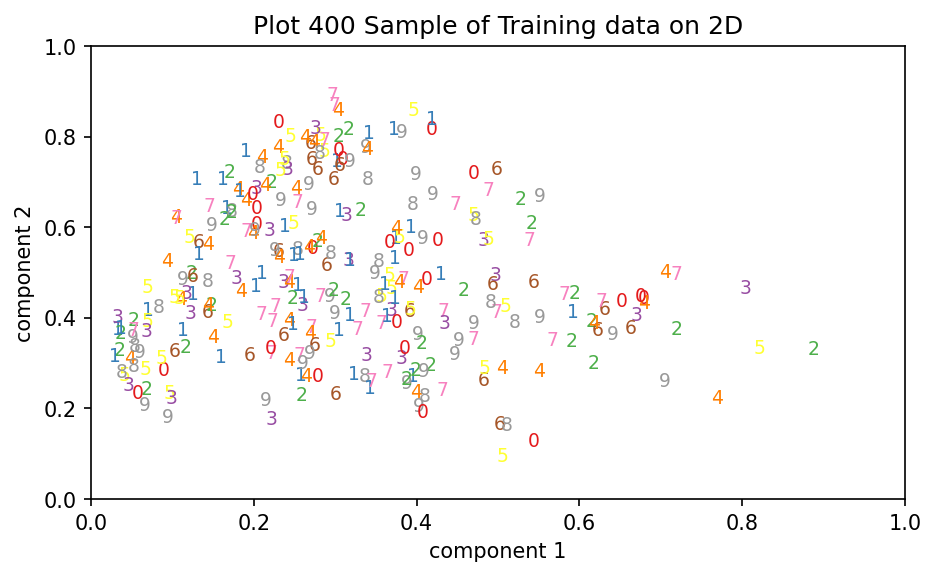

In [31]:
#Plot 400 Sample of Training data on 2
# normalize data to [0,1] after PCA tranform before plotting samples 
x_min, x_max = np.min(X_train_new, 0), np.max(X_train_new, 0)
X_e = (X_train_new - x_min) / (x_max - x_min)
plt.figure(figsize=(7, 4), dpi=150)
for i in range(300):
    plt.text(X_e[i, 0], X_e[i, 1], str(y_test[i]),
             color=plt.cm.Set1(y_test[i]), 
             fontdict={'size': 9})
# plt.xticks([]), plt.yticks([])
       
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Plot 400 Sample of Training data on 2D')
plt.show


    

I transoform the test data using the trained PCA model then visualize it. 

Explained variation by the two principal components : [0.09704664 0.07095924] respectively


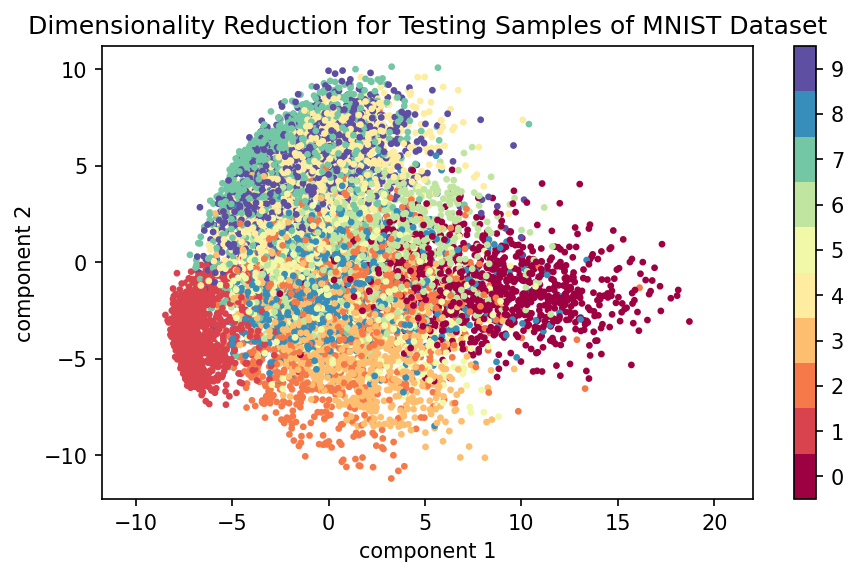

In [33]:
# reduce test dataset dimensions to 2D  
X_test_new = pca.transform(x_test)
plt.figure(figsize=(7, 4), dpi=150)
plt.scatter(X_test_new[:, 0], X_test_new[:, 1],
             s= 5, c=y_test, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Dimensionality Reduction for Testing Samples of MNIST Dataset')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))

Visualize only the first 400 test sampling the number itself as a marker.

<function matplotlib.pyplot.show(close=None, block=None)>

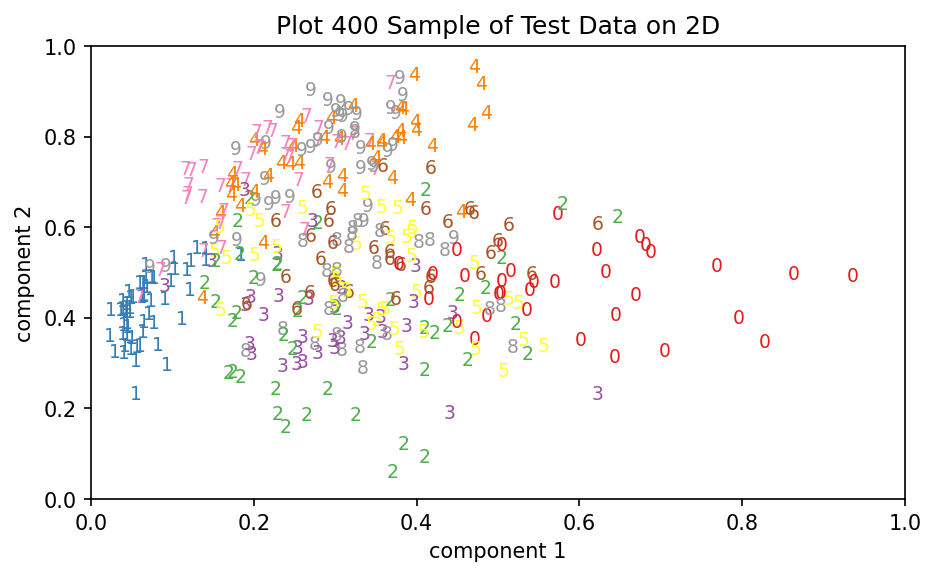

In [34]:
#Plot 400 Sample of testing data on 2D
x_min, x_max = np.min(X_test_new, 0), np.max(X_test_new, 0)
X_e = (X_test_new - x_min) / (x_max - x_min)
plt.figure(figsize=(7, 4), dpi=150)
for i in range(400):
    plt.text(X_e[i, 0], X_e[i, 1], str(y_test[i]),
             color=plt.cm.Set1(y_test[i]), 
             fontdict={'size': 9})
       
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.title('Plot 400 Sample of Test Data on 2D')
plt.show



we note above that 2-components PCA does not explain much of data variance. to answer how many components can cover 95% of data variance we refitted another PCA model with the training data.

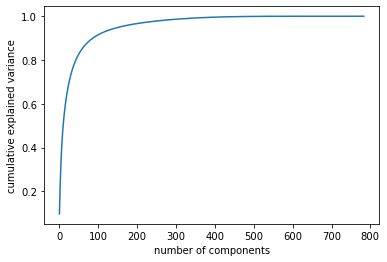

In [30]:
# build a plot between N. PCA components vs. cumulative explained variance
pca = PCA().fit(x_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [7]:
#we can find out the number of features that explain 95% of data variance
pca = PCA(0.95).fit(x_train)
print(f'{len(pca.components_)} features carry 95% of data variance')

154 features carry 95% of data variance


In order to carry out a viual inspection of each pair, we plot every pair and check which pair can be linearly seperable. 

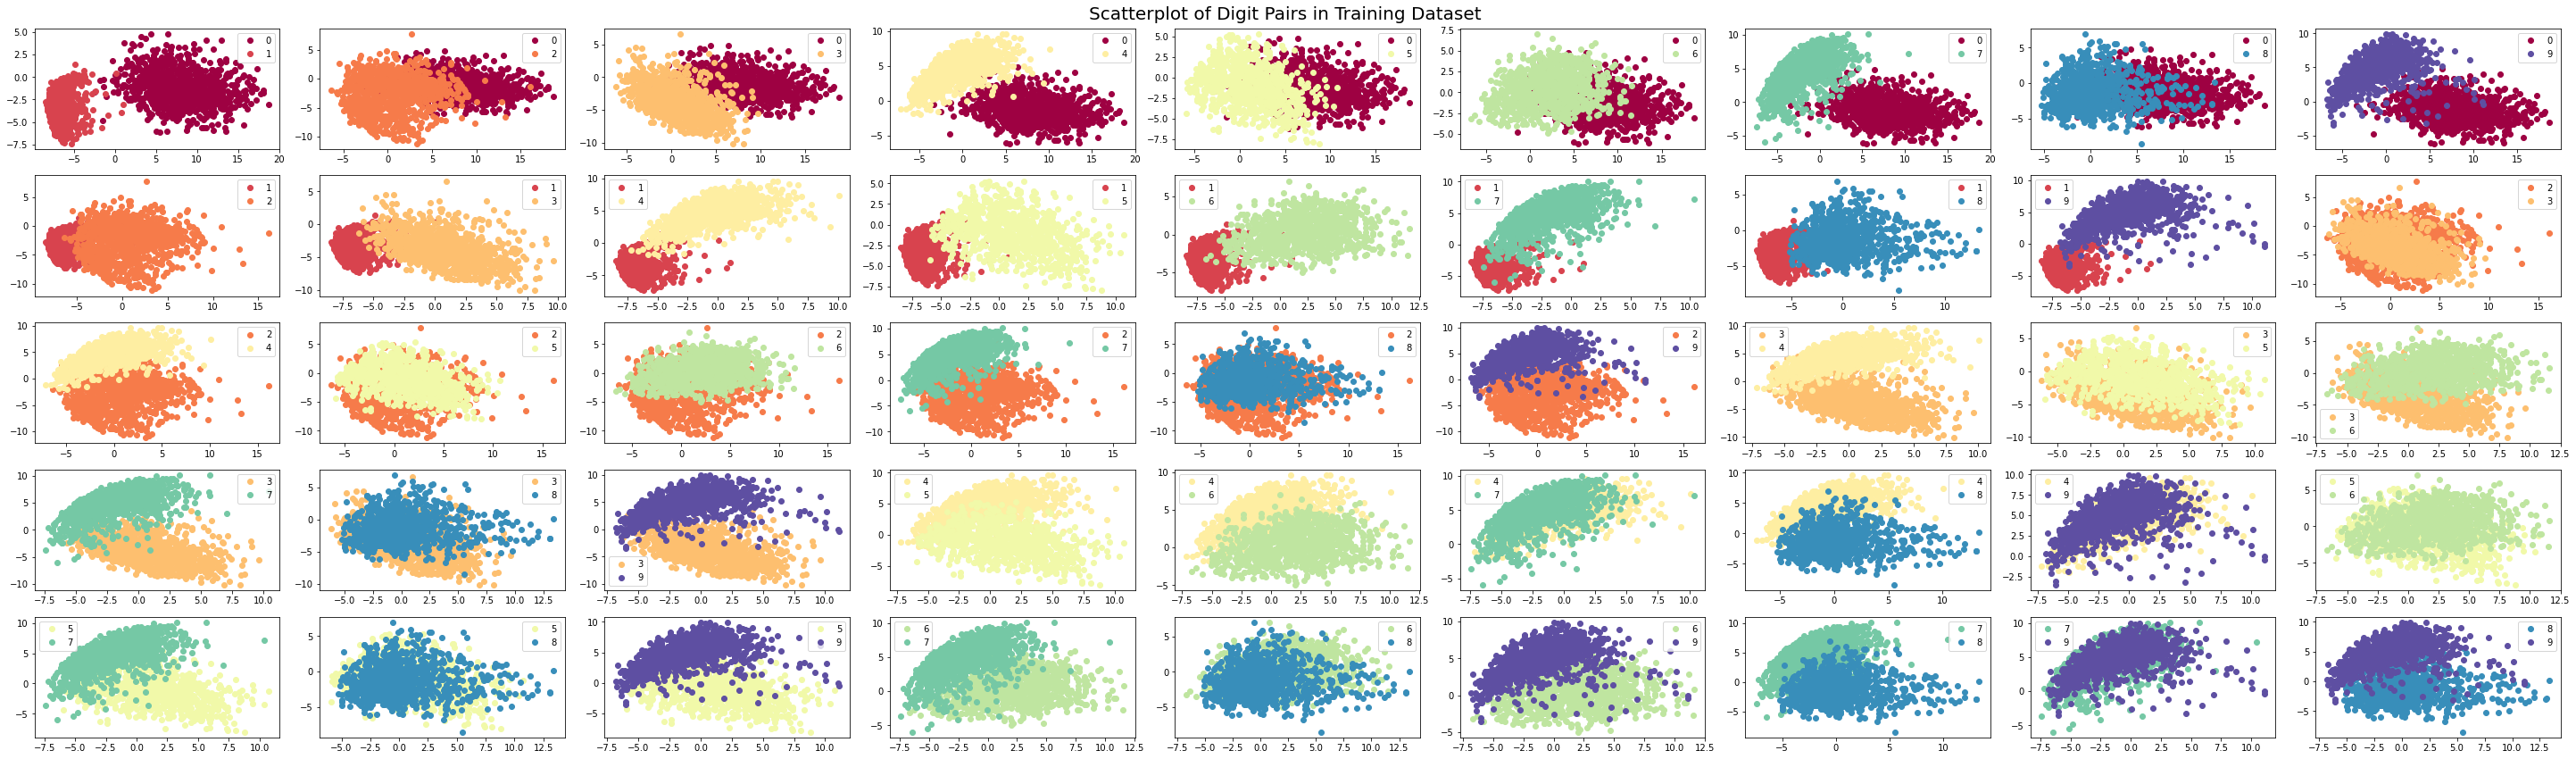

In [40]:
# scatter plot all combinations of datapoints in test dataset to visually inspect which are linearly seperated by PCA. 
colours = plt.cm.get_cmap('Spectral', 10)
n_unique_labels = len(np.unique(y_train))
comb = combinations(range(10), 2)
fig, axar = plt.subplots(5,9, figsize=(40, 12))
for ax, pair in zip(axar.ravel(), comb):
    for set_ in pair:
        temp = X_test_new[y_test==set_]
        ax.plot(temp[:,0], temp[:,1],  'o', c=colours(set_), label = set_)
    ax.legend()
fig.suptitle('Scatterplot of Digit Pairs in Training Dataset', fontsize=20)
fig.tight_layout()
  

# Task 2: Perceptrons


I build a function that take our original data and return new binary x and y based on the chosen pair.

In [3]:
def convert_to_binary(pair, x, y):
    cond = (y == pair[0]) + (y == pair[1])
    binary_x = x[cond,:]
    binary_y = y[cond]*1.
    binary_y[binary_y== pair[0]] = -1
    binary_y[binary_y == pair[1]] = 1
    return binary_x, binary_y

## Task 2.1

Predict function will take input, linearly feed it forward and run a step activiation function on it then return prediction of 1- and 1

In [4]:
def predict(x, w, b):
    z = np.dot(x, w) + b
    return np.sign(z)

## Task 2.2:

optimize function will take a learning rate and the input x and y dataset. The method will run a loop to optimize the learning and reach a local minmum of the cost function. 

When learning rate is 0.004, single perceptron learning progresses as following:
epoch 1, loss = 0.013896565337544414
epoch 2, loss = 0.0024476904855902093
epoch 3, loss = 0.0015791551519936833
epoch 4, loss = 0.0014212396367943151
epoch 5, loss = 0.0015791551519936833
epoch 6, loss = 0.0011054086063955783
epoch 7, loss = 0.0011054086063955783
epoch 8, loss = 0.0010264508487958942
epoch 9, loss = 0.0006316620607974733
epoch 10, loss = 0.0009474930911962101
epoch 11, loss = 0.0007895775759968417
epoch 12, loss = 0.0007895775759968417
epoch 13, loss = 0.0006316620607974733
epoch 14, loss = 0.0007895775759968417
epoch 15, loss = 0.00039478878799842083
epoch 16, loss = 0.0005527043031977891
epoch 17, loss = 0.00015791551519936834
epoch 18, loss = 0.0003158310303987367
epoch 19, loss = 0.00015791551519936834
epoch 20, loss = 7.895775759968417e-05
epoch 21, loss = 0.00039478878799842083
epoch 22, loss = 0.00039478878799842083
epoch 23, loss = 0.0007106198183971576
epoch 24, loss = 0.0


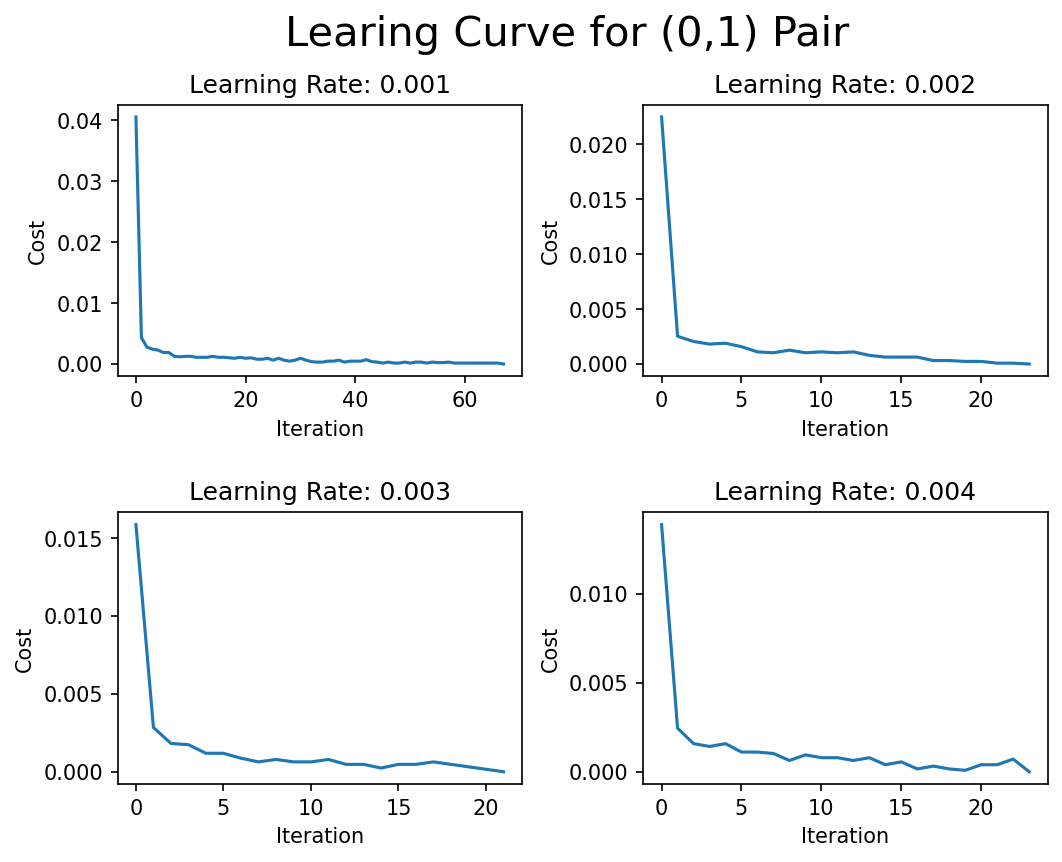

In [6]:
def optimize(x, y, learning_rate, verbose = False):
    starttime = timeit.default_timer()
    iter_ = 0 
    empirical_loss = np.inf
    n,m = x.shape # n: number of training samples, m: number of features
    b = np.random.rand()
    w = np.random.rand(m)
    learning_rate = learning_rate 
    costs = []
    while (iter_ <= 1000) & (empirical_loss > 1e-3): 
        
        empirical_loss = 0
        for x_i, y_i in zip(x, y):            
            #Feed Foraward
            y_predict = predict(x_i, w, b)
            
            # class dissimilarity loss function
            empirical_loss += max(0, - y_i * y_predict)
            if y_i != y_predict:
                # gradient descent
                w = w + learning_rate * (y_i - y_predict) * x_i 
                b = b + learning_rate * (y_i - y_predict) 
                
        iter_ += 1
        costs.append(empirical_loss/n)
        if verbose:
            print(f'epoch {iter_}, loss = {empirical_loss/n}')
    training_time =  timeit.default_timer() - starttime
    return w, b, costs, iter_, training_time

binary_x_train, binary_y_train = convert_to_binary((0,1),x_train,y_train)

i = 1
verbose = False
plt.figure(figsize=(8, 6), dpi=150)
for lr in np.arange(0.001, 0.005, 0.001):
    if i== 4:
        verbose = True
        print(f'When learning rate is {lr}, single perceptron learning progresses as following:')
    the_w, the_b, training_error, iter_, training_time = optimize(binary_x_train, binary_y_train, lr, verbose)   
    plt.subplot(2,2,i)
    plt.plot(range(iter_), training_error)
    plt.xlabel('Iteration')
    plt.ylabel('Cost')
    plt.title(f"Learning Rate: {lr}")
    i += 1
plt.suptitle('Learing Curve for (0,1) Pair', fontsize=20)

plt.subplots_adjust(hspace=0.5, wspace = 0.3)
plt.show()

We demonstrate the weights that one neurons learn when initiating learning process with Learning rate is 0.08.

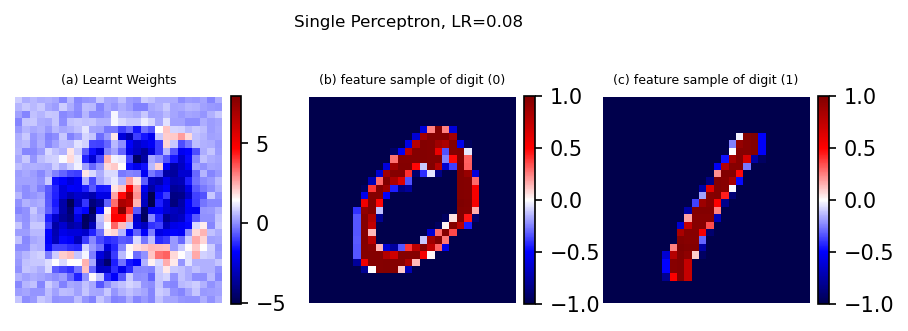

In [11]:
# Demonstrate 𝑤 as an image with the same size as inputs).
the_w, the_b, training_error, iter_, training_time = optimize(binary_x_train, binary_y_train, 0.08) 
fig = plt.figure(figsize=(7, 2), dpi=150)
fig.add_subplot(1,3,1)
im1 = plt.imshow(the_w.reshape(-1,28), cmap='seismic')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('(a) Learnt Weights', fontsize=6)
fig.add_subplot(1,3,2)
im1 = plt.imshow(binary_x_train[0].reshape(-1,28), cmap='seismic')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('(b) feature sample of digit (0)', fontsize=6)

fig.add_subplot(1,3,3)
im1 = plt.imshow(binary_x_train[1].reshape(-1,28), cmap='seismic')
plt.colorbar(im1,fraction=0.046, pad=0.04)
plt.axis('off')
plt.title('(c) feature sample of digit (1)', fontsize=6)
plt.suptitle('Single Perceptron, LR=0.08', fontsize=8, y=1.12)
plt.subplots_adjust( wspace = 0.3)
plt.show()

When training the perceptron to distinguish between 2 and 3 digits, we note that loss fluctuates quiet a bit and never reach the predefined error threshold (i.e. 0.001)

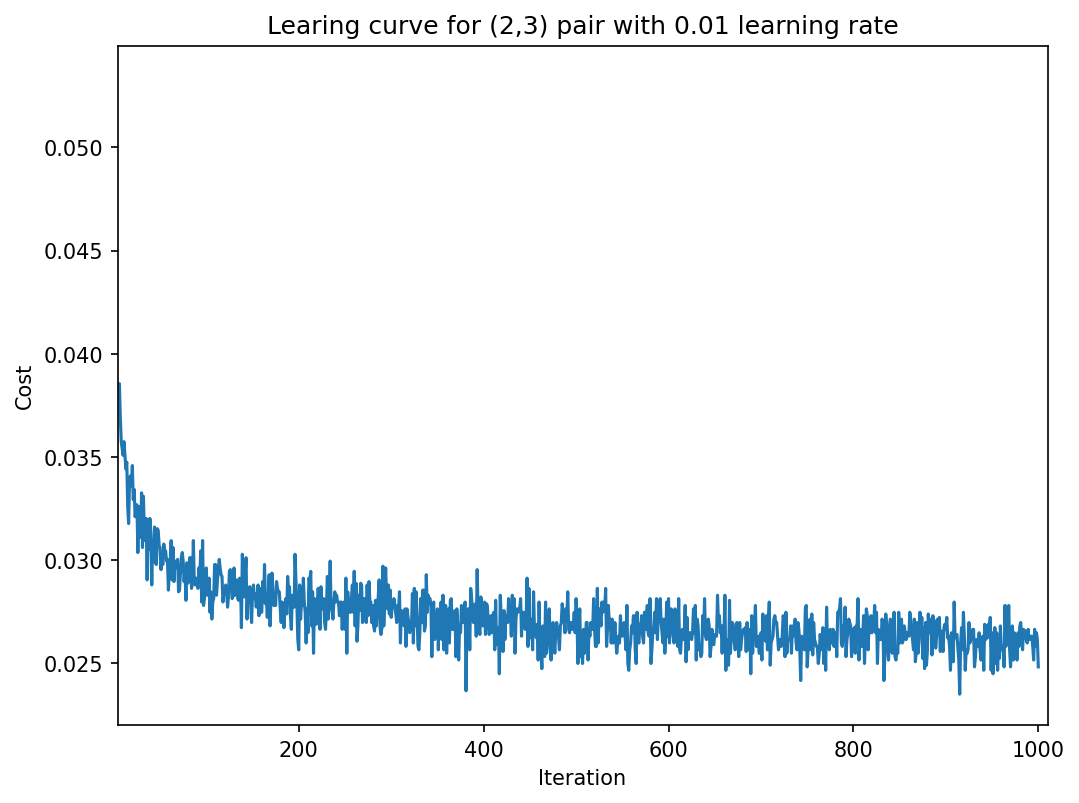

In [8]:
binary_x_train, binary_y_train = convert_to_binary((2,3),x_train,y_train)

plt.figure(figsize=(8, 6), dpi=150)
lr = 0.01
the_w, the_b, training_error, iter_, training_time = optimize(binary_x_train, binary_y_train, lr)   
plt.plot(range(iter_), training_error)
plt.xlabel('Iteration')
plt.ylabel('Cost')
plt.xlim([4,1010])
# plt.ylim([900,1600])

plt.title(f"Learing curve for (2,3) pair with 0.01 learning rate")
plt.subplots_adjust(hspace=0.5, wspace = 0.3)
plt.show()

I can use the percecptron to find all linearly seperable pairs. I went on and try all possible pair combinations. To avoid long training time, I setup an alarm that cancel a pair training when time exceed 8 sec (empirical number enough to train a linear seperated pair). 

In [29]:
import signal

class TimeoutException(Exception):   # Custom exception class
    pass

def timeout_handler(signum, frame):   # Custom signal handler
    raise TimeoutException

# linearly seperated data
def predict_accuracy_plot_examplee(binary_x_train, binary_y_train, binary_y_test, binary_x_test, pair):
    the_w, the_b, training_error, iter_, training_time = optimize(binary_x_train, binary_y_train, 0.005)
    print(pair,f' pair took %.2f sec after going for {iter_} iteration' % training_time)

# Change the behavior of SIGALRM
signal.signal(signal.SIGALRM, timeout_handler)

print('Following is a list of linearly seperable pairs:')
    
for pair in combinations(range(0,10), 2):
    binary_x_train, binary_y_train = convert_to_binary(pair,x_train,y_train)
    binary_x_test, binary_y_test = convert_to_binary(pair,x_test,y_test)
    #
    signal.alarm(8)
    try:
        accuracy_ = predict_accuracy_plot_examplee(binary_x_train, binary_y_train, binary_y_test, binary_x_test, pair)
    except TimeoutException:
        continue
    else:
        # Reset the alarm
        signal.alarm(0)



Following is a list of linearly seperable pairs:
(0, 1)  pair took 2.36 sec after going for 24 iteration
(0, 4)  pair took 4.62 sec after going for 52 iteration
(0, 7)  pair took 2.51 sec after going for 36 iteration
(1, 6)  pair took 2.37 sec after going for 30 iteration
(3, 6)  pair took 6.12 sec after going for 82 iteration
(6, 7)  pair took 2.34 sec after going for 23 iteration
(6, 9)  pair took 1.40 sec after going for 19 iteration


we repeat training/testing procedure to classify different pairs then plot some examples of the predict/true label along with the image sample 

1 ...
Accuracy for (0, 1) pair is 99.91 percent on test data.
Perceptron was trained for 1.98 sec in 19 iterations.
2 ...
Accuracy for (2, 3) pair is 94.37 percent on test data.
Perceptron was trained for 80.61 sec in 1001 iterations.
3 ...
Accuracy for (2, 4) pair is 97.42 percent on test data.
Perceptron was trained for 67.78 sec in 1001 iterations.
4 ...
Accuracy for (8, 3) pair is 95.46 percent on test data.
Perceptron was trained for 75.68 sec in 1001 iterations.
5 ...
Accuracy for (9, 4) pair is 96.53 percent on test data.
Perceptron was trained for 71.20 sec in 1001 iterations.
6 ...
Accuracy for (5, 6) pair is 94.05 percent on test data.
Perceptron was trained for 71.55 sec in 1001 iterations.
7 ...
Accuracy for (0, 7) pair is 99.40 percent on test data.
Perceptron was trained for 2.95 sec in 37 iterations.
8 ...
Accuracy for (1, 2) pair is 98.57 percent on test data.
Perceptron was trained for 99.41 sec in 1001 iterations.


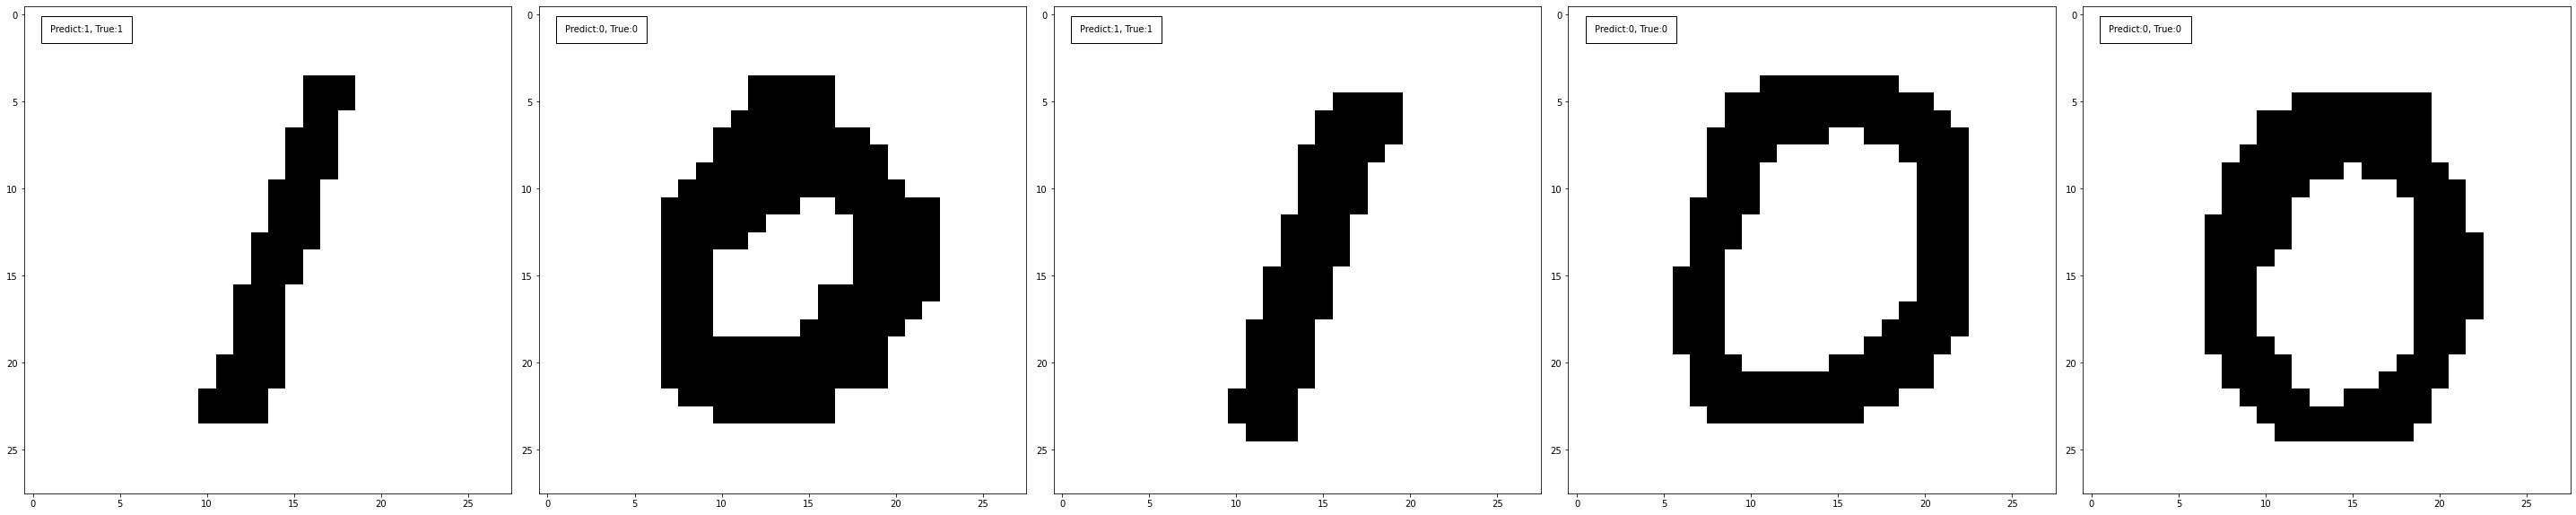

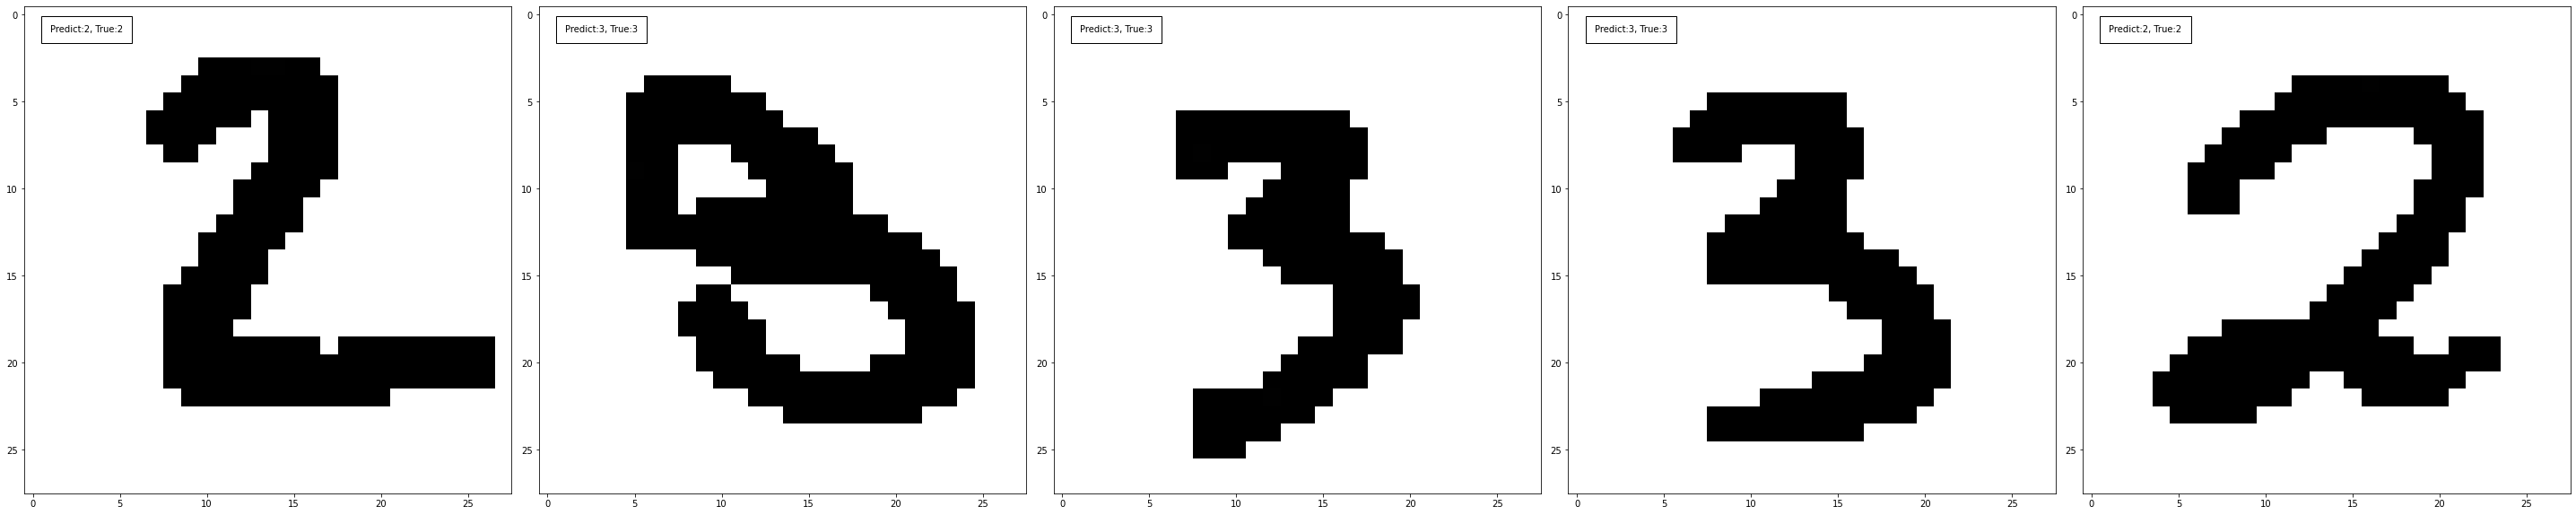

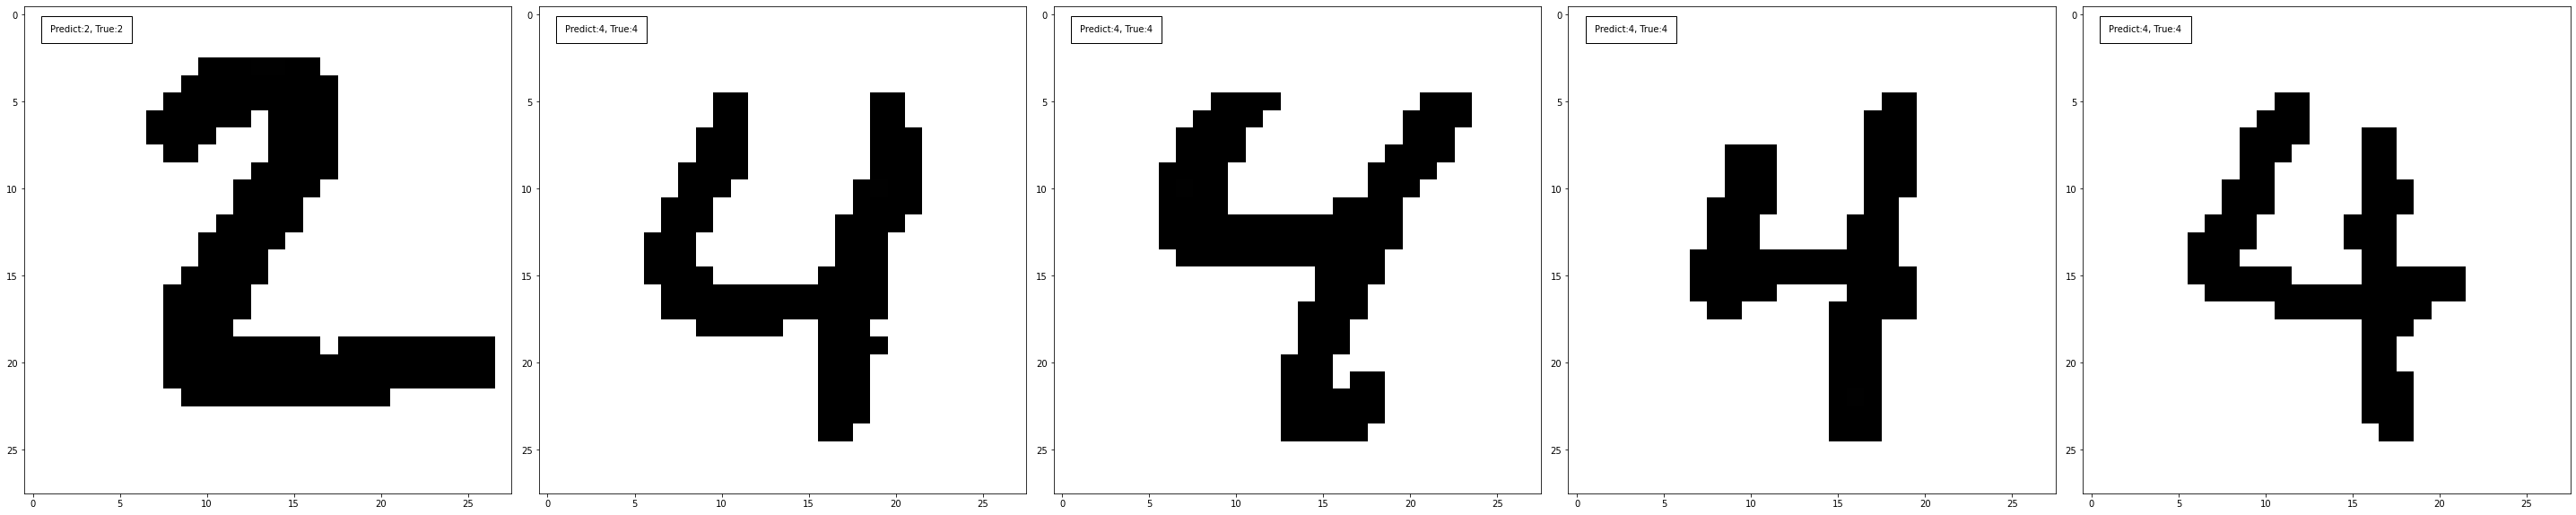

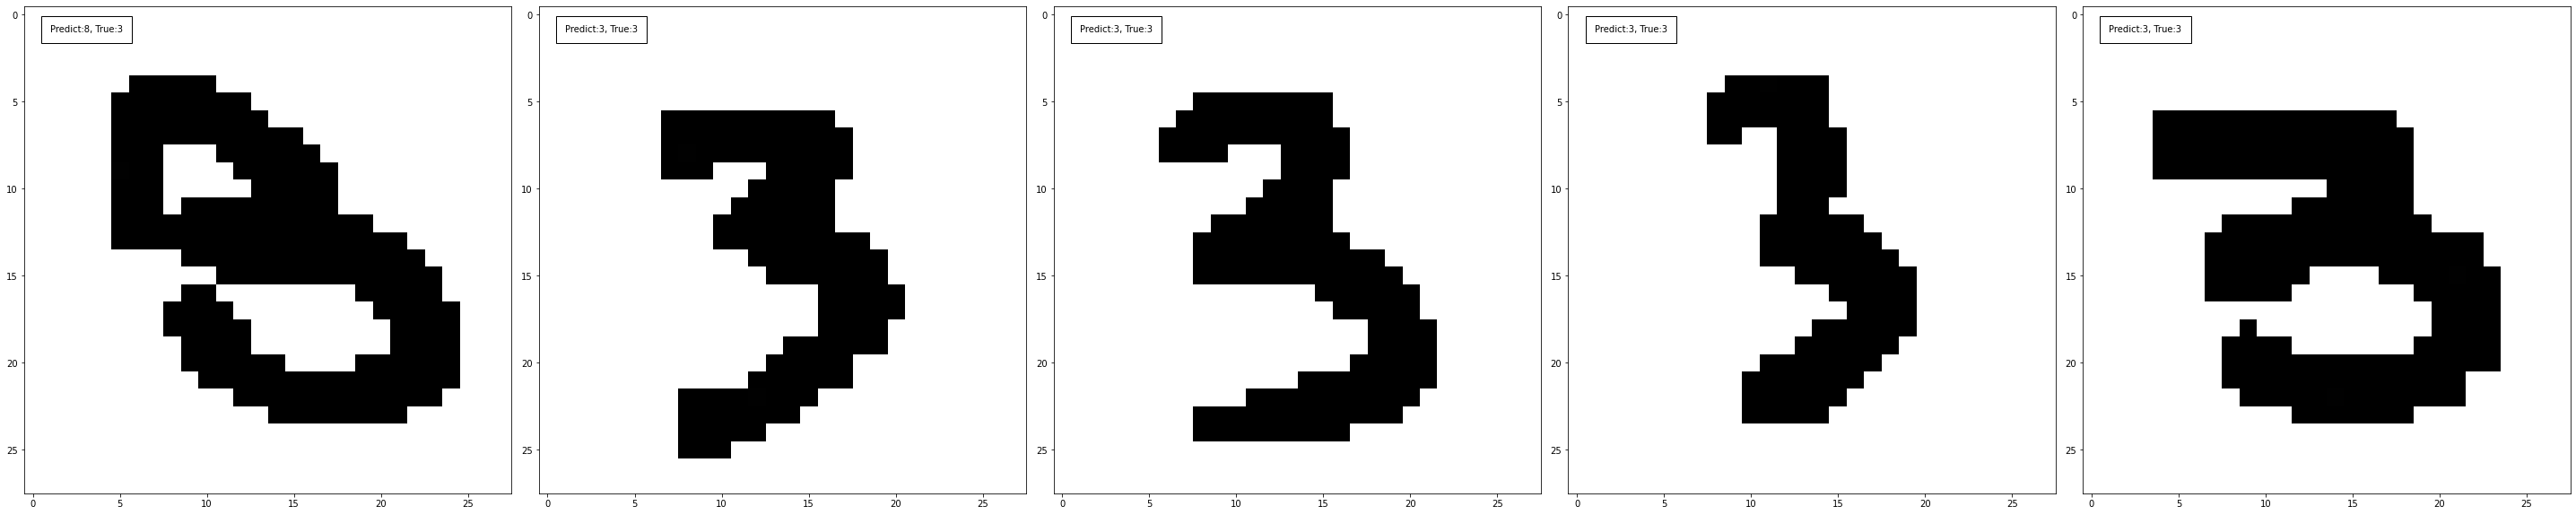

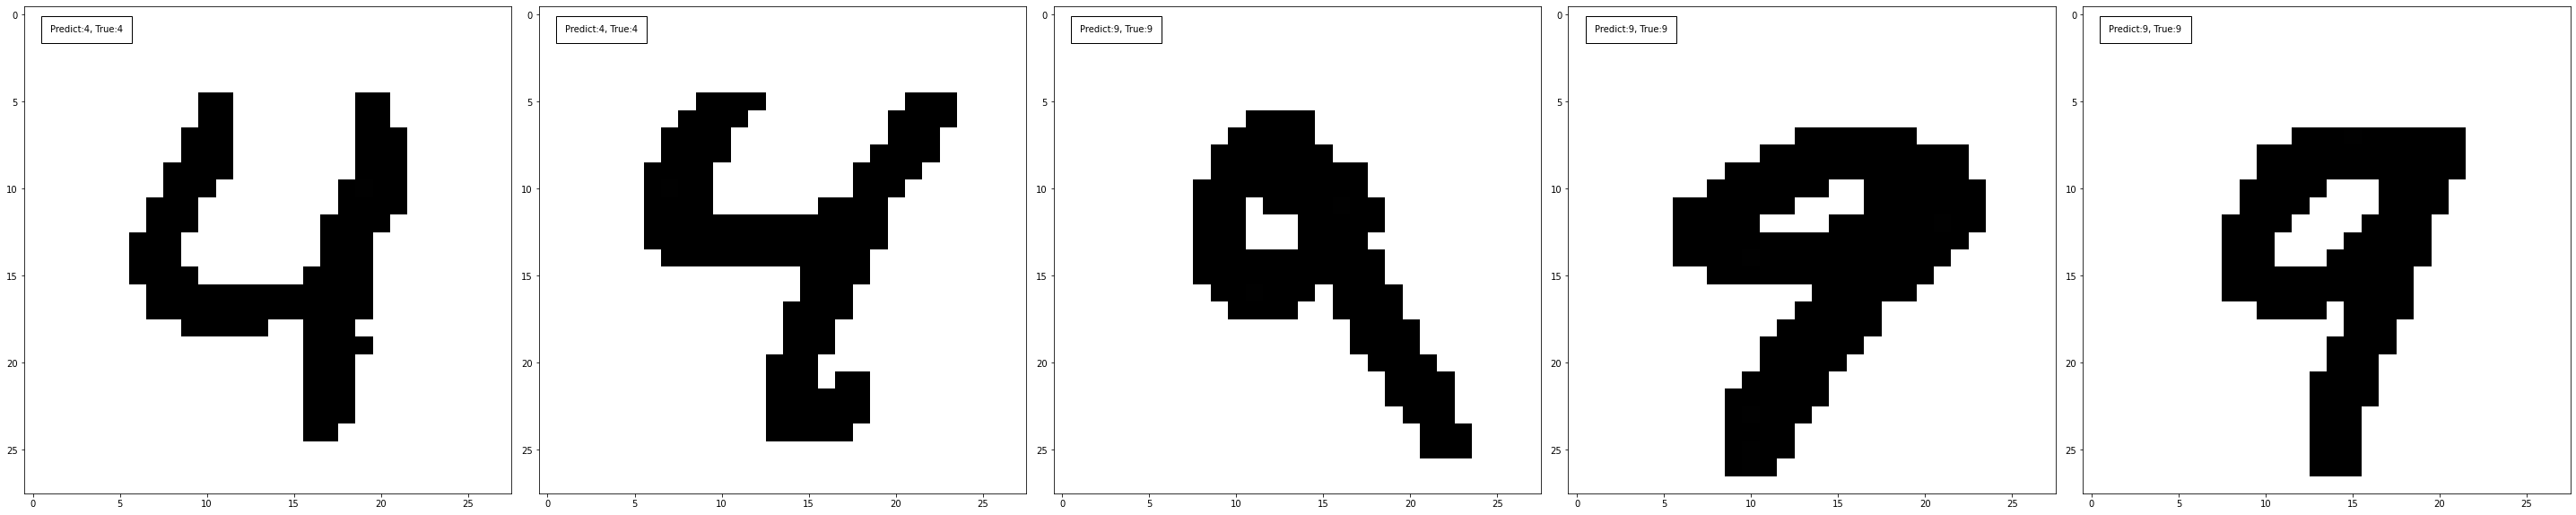

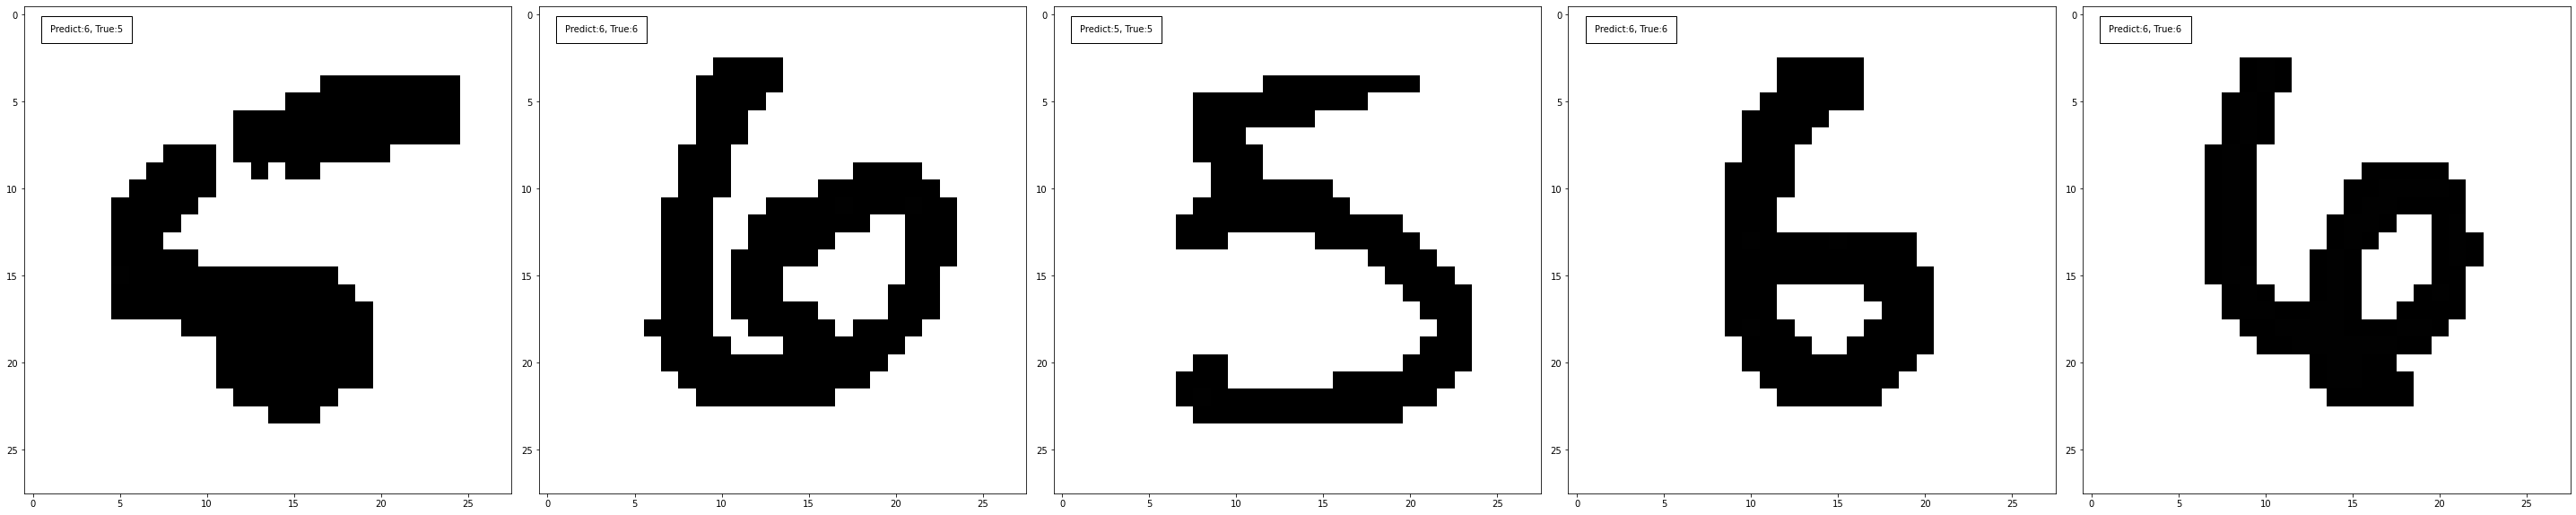

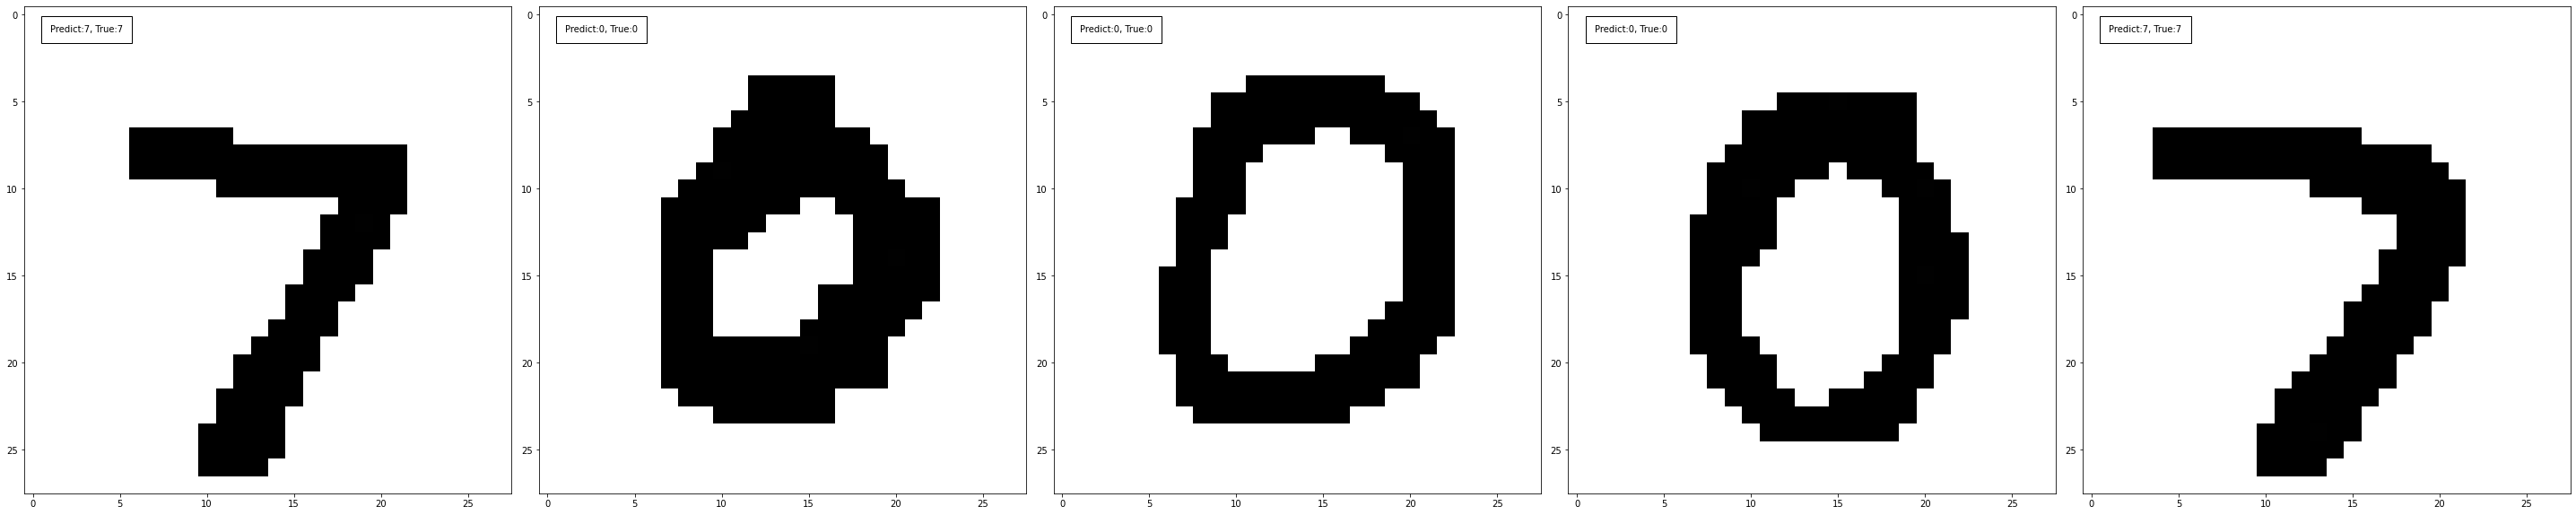

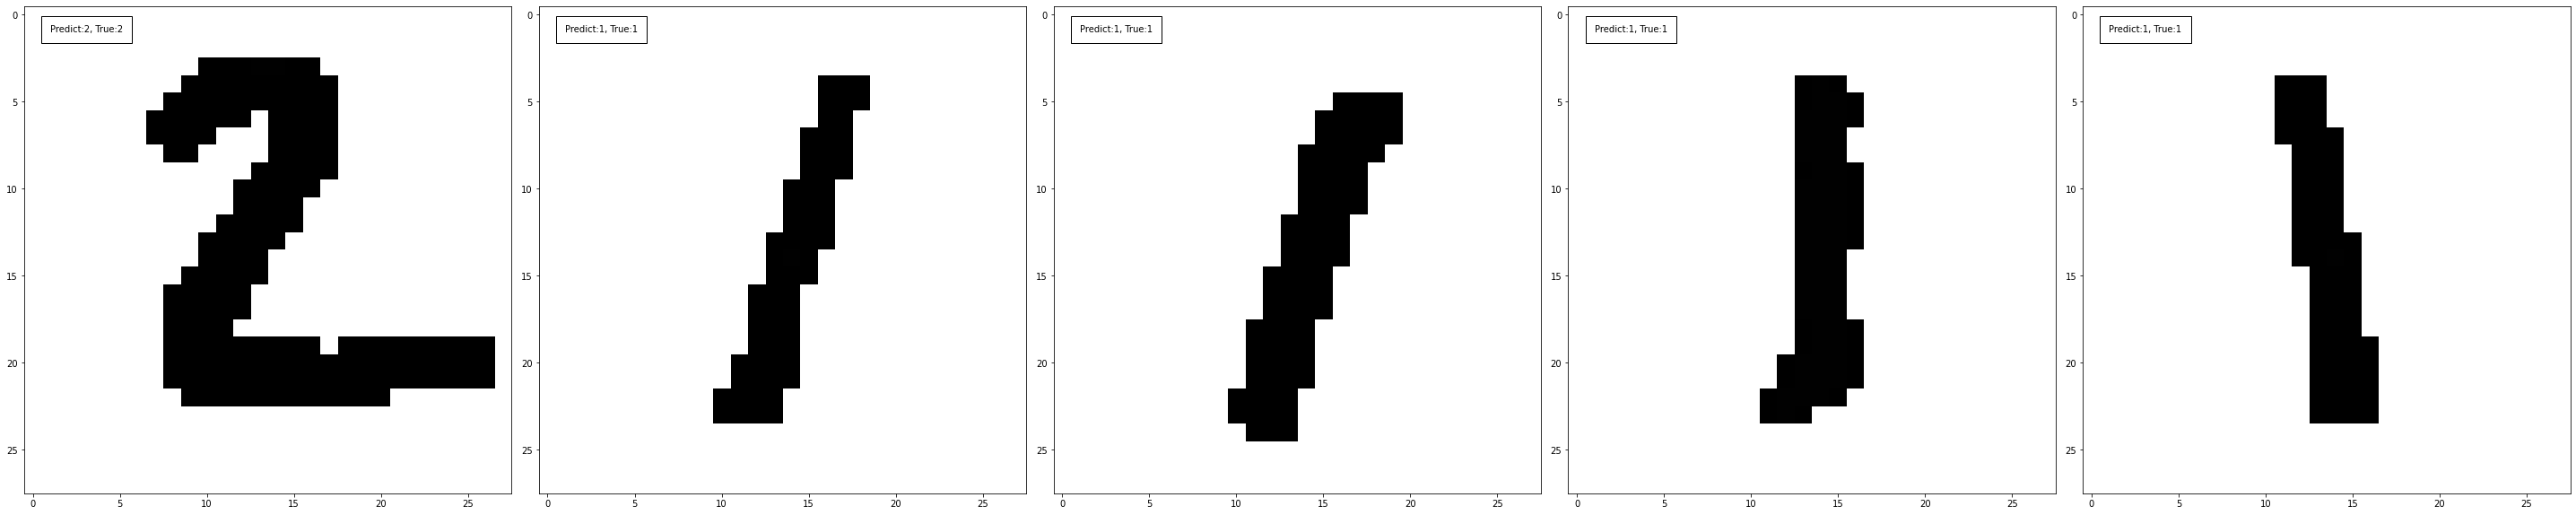

In [49]:
def accuarcy(y_true, y_predict):
    return len(y_true[y_predict==y_true])/len(y_true)

def predict_accuracy_plot_examples(binary_x_train, binary_y_train, binary_y_test, binary_x_test, pair):
    # fit a perceptron with the pair dataset
    the_w, the_b, training_error, iter_, training_time = optimize(binary_x_train, binary_y_train, 0.005)

    # feedforward and activation function, measure accuracy 
    y_predict = predict(binary_x_test, the_w, the_b)
    accuracy_ = accuarcy(binary_y_test, y_predict)

    print(f'Accuracy for {pair} pair is %.2f percent on test data.' % (accuracy_*100))
    print(f'Perceptron was trained for %.2f sec in {iter_} iterations.' % training_time )

    # plot samples
    fig, axar = plt.subplots(1, 5, figsize=(40, 12))
    i = 0
    for y_predict, y_true, x, ax in zip(y_predict, binary_y_test, binary_x_test, axar.ravel()):
        arr = x.astype('uint8').reshape(-1,28)
        Img = imge.fromarray(arr, 'L')
        ax.imshow(Img, cmap='gray')
        if y_predict == -1: 
            y_predict = pair[0]
        elif y_predict == 1:
            y_predict = pair[1]
        if y_true == -1: 
            y_true = pair[0]
        elif y_true == 1:
            y_true = pair[1]   
        ax.text(1, 1, f'Predict:{y_predict}, True:{y_true}', bbox={'facecolor': 'white', 'pad': 10})
        i += 1
        if i == 5:
            break

    fig.tight_layout()
    return accuracy_

   
# try different pairs
i =1
for pair in [(0,1), (2,3), (2, 4), (8,3), (9, 4), (5,6), (0,7), (1, 2)]:
    print(i, '...')
    binary_x_train, binary_y_train = convert_to_binary(pair,x_train,y_train)
    binary_x_test, binary_y_test = convert_to_binary(pair,x_test,y_test)
    accuracy_ = predict_accuracy_plot_examples(binary_x_train, binary_y_train, binary_y_test, binary_x_test, pair)
    i +=1
   